<p><font size="4"><i>
In this notebook, I want to explore survival time prediction from features in the SEER Breast Cancer Dataset.

In [1]:
#general:
import numpy as np
import pandas as pd

#for plotting:
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn modules
## Classifier to be used:
from sklearn import svm
from sklearn.svm import SVR
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn import linear_model
from sklearn.linear_model import Lasso, Ridge, LinearRegression, lasso_path
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

# For data prep:
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel

# For model evaluation:
from sklearn.metrics import accuracy_score
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# Time functions
import datetime
from datetime import datetime, timedelta

# For output:
from ipywidgets import Output
import IPython.display as display

# Let's ignore the warnings:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Read the pickles created in DatsetBldg Notebook ( current directory)
# First the standardized training data
df_Xtr = pd.read_pickle("df_Xtr_fs.pck")
df_Xts = pd.read_pickle("df_Xts_fs.pck")

#Labels that have not been transformed:
df_ytr = pd.read_pickle("df_ytr.pck")
df_yts = pd.read_pickle("df_yts.pck")

#Transformed labels
df_ytr_sqr = pd.read_pickle("df_ytr_sqr.pck")
df_yts_sqr = pd.read_pickle("df_yts_sqr.pck")

#Convert the df to numpy arrays:
Xtr = df_Xtr.to_numpy()
Xts = df_Xts.to_numpy()

ytr = df_ytr.to_numpy()
yts = df_yts.to_numpy()

ytr_sqr = df_ytr_sqr.to_numpy()
yts_sqr = df_yts_sqr.to_numpy()

In [3]:
# Read the pickles created in DatsetBldg Notebook ( current directory)
# First the standardized training data
df_Xtr = pd.read_pickle("df_Xtr_fs.pck")
df_Xts = pd.read_pickle("df_Xts_fs.pck")

#Labels that have not been transformed:
df_ytr = pd.read_pickle("df_ytr.pck")
df_yts = pd.read_pickle("df_yts.pck")

#Transformed labels
df_ytr_sqr = pd.read_pickle("df_ytr_sqr.pck")
df_yts_sqr = pd.read_pickle("df_yts_sqr.pck")

#Convert the df to numpy arrays:
Xtr = df_Xtr.to_numpy()
Xts = df_Xts.to_numpy()

ytr = df_ytr.to_numpy()
yts = df_yts.to_numpy()

ytr_sqr = df_ytr_sqr.to_numpy()
yts_sqr = df_yts_sqr.to_numpy()

<p><font size="4"><i>
Train the a base line Linear Regression model on all features

In [4]:
lr = LinearRegression()
lr.fit(Xtr, ytr)
lr.coef_

array([-2.42537494, -1.31607247, -0.34080549,  0.94627192,  1.32383998,
       -0.94392952,  0.13145035, -0.38248521,  9.43304813,  9.75771944,
        8.56903511, -2.364467  ,  1.04765361,  1.31681338, -1.91716869,
        4.12923595,  0.61987513, -1.84132006, -0.99062233])

<p><font size="4"><i>
Evaluate the model on the training error:

In [5]:
# Evaluate the model
ytr_pred = lr.predict(Xtr)

mse = mean_squared_error(ytr, ytr_pred)
print("Mean Squared Error on training data:", mse)

r2 = r2_score(ytr, ytr_pred)
print("R-squared:", r2)

Mean Squared Error on training data: 506.8302623588991
R-squared: 0.11957656161427421


<p><font size="4"><i>
The MSE is quite high, and the R^2 is quite low.

<p><font size="4"><i>
Let's looks at the residuals.

* Histogram for distribution
* Scatter plot vs target
* Scatter plot vs prediction

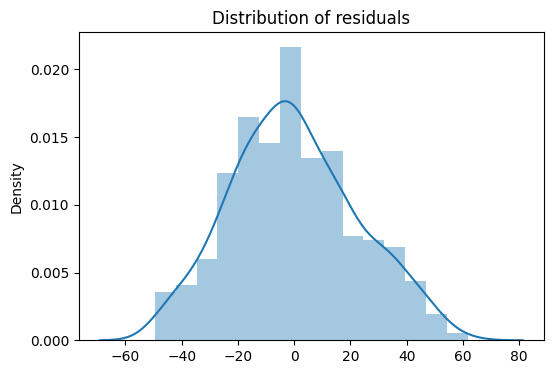

In [6]:
residuals = ytr - ytr_pred
residuals_sqd = residuals**2

# Creating a Histogram of Residuals
plt.figure(figsize=(6,4))
sns.distplot(residuals)
plt.title('Distribution of residuals')
plt.show()

<p><font size="4"><i>
The shape is roughly symmetric, normally distributed with a mean of close to 0. That's good. However, the spread is high, that's a concern. 


<p><font size="4"><i>
The shape is roughly symmetric, normally distributed with a mean of close to 0. That's good. However, the spread is high, that's a concern. 


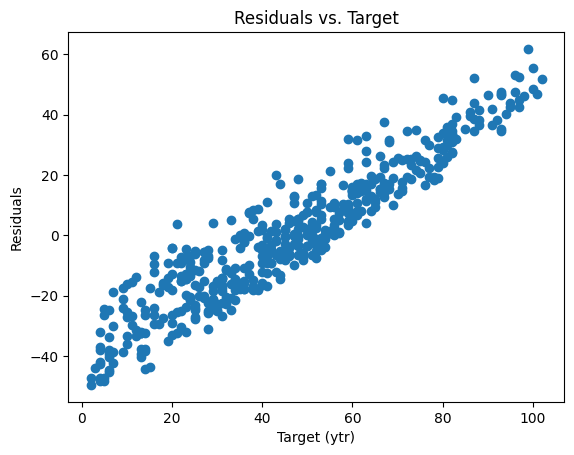

In [7]:
plt.scatter(ytr, residuals)
plt.savefig('residuals_vs_target.png')
plt.xlabel("Target (ytr)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Target")
plt.show()

<p><font size="4"><i>
Looks like a strong linear trend. This may suggests that the model has high bias (underfit/overly simplistic). 


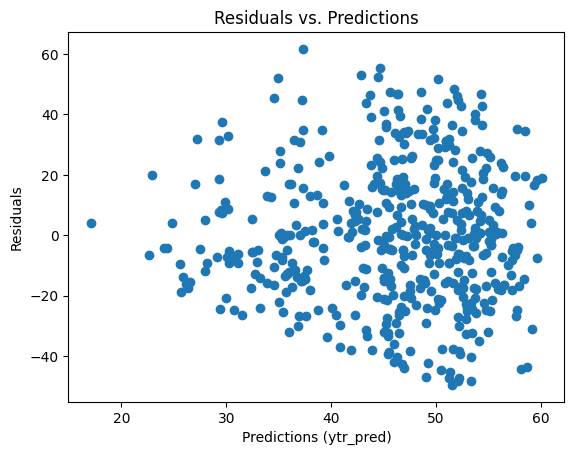

In [8]:
plt.scatter(ytr_pred, residuals)
plt.savefig('residuals_vs_prediction.png')
plt.xlabel("Predictions (ytr_pred)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Predictions")
plt.show()

<p><font size="4"><i>
The cone shape indicates heteroskedasticity (the spread of errors varies depends on the predicted values). Heteroscedasticity is a problem because ordinary least squares (OLS) regression assumes that all residuals are drawn from a population that has a constant variance.

(https://statisticsbyjim.com/regression/heteroscedasticity-regression/)

There are several strategies to improve the performance:  

* Heteroskedasticity -> label transformation and weighted regression.
* Feature Engineering -> Scaling and centering have already been applied. 
* Gradient Boosting
* Neural Networks -> Lack of data if only considering dead people. 
    
Next, let's retrain the model using square root transformation on the labels

In [9]:
# Train the a base line Linear Regression model on all features
lr_sqt = LinearRegression()
lr_sqt.fit(Xtr, ytr_sqr)
lr_sqt.coef_

array([-0.223907  , -0.09290393, -0.00981931,  0.0959705 ,  0.08903433,
       -0.11735525,  0.02810102, -0.04090703,  0.69303262,  0.79210999,
        0.6671016 , -0.15515542,  0.03802765,  0.11712777, -0.16116485,
        0.35531664,  0.07531248, -0.20098996, -0.06847431])

In [10]:
# Evaluate the model
ytr_pred = lr_sqt.predict(Xtr)

# Apply an inverse transformation on the predictions:
ytr_pred_trans = ytr_pred**2

mse = mean_squared_error(ytr, ytr_pred_trans)
print("Mean Squared Error on training data:", mse)

r2 = r2_score(ytr, ytr_pred_trans)
print("R-squared:", r2)

Mean Squared Error on training data: 519.6691227513226
R-squared: 0.0972739596365585


<p><font size="4"><i>
Worse!

Let's try weighted regression. First step is to calculate a weight vector. An overall average variance could be used, but maybe it is better to split up the data into bins.

In [11]:
# Step 1: Create bins for the target variable 
df_wr = pd.DataFrame({'target': ytr.flatten(), 'residuals': residuals.flatten()})
df_wr['target_bin'] = pd.cut(df_wr['target'], bins=10)  # Let's guess at 10 bins

# Step 2: Calculate the variance of residuals within each bin
variance_by_bin = df_wr.groupby('target_bin')['residuals'].var().reset_index() 

# Step 2b: Rename for clarity (optional)
variance_by_bin.columns = ['target_bin', 'variance']

# Step 3 : Map the variance back using the original target bin (ensures float type)
df_wr = df_wr.merge(variance_by_bin, on='target_bin', how='left')

# Step 4: Calculate weights as the inverse of variance
df_wr['weights'] = 1 / (df_wr['variance'] + 1e-8)  # Ensures variance is float

# Optional: View the weights for each row
print(df_wr[['target', 'residuals', 'variance', 'weights']])

     target  residuals    variance   weights
0        44 -13.173514   51.607722  0.019377
1        98  46.012447   42.738980  0.023398
2        39   8.789744   76.568665  0.013060
3        28 -24.929715   56.848648  0.017591
4        61   6.678952   63.204032  0.015822
..      ...        ...         ...       ...
487      16 -29.253589  135.602083  0.007375
488      22 -15.234468  135.602083  0.007375
489      41  -0.730363   76.568665  0.013060
490      59  22.142036   63.204032  0.015822
491      21 -32.467888  135.602083  0.007375

[492 rows x 4 columns]


In [12]:
lr_weighted = LinearRegression()
lr_weighted.fit(Xtr, ytr, sample_weight=df_wr['weights'])
lr_weighted.coef_

array([-1.01156195, -1.50236031, -0.65480448,  0.17654589,  2.07616539,
        0.63314228, -0.51382243, -1.10422618, 12.73080071,  7.76757005,
        9.74874899, -2.98610856,  2.55889426,  0.4272143 , -2.10806056,
        4.54983522,  0.27129658,  0.01430428, -2.72737552])

Mean Squared Error on training data: 548.381223272392
R-squared: 0.04739768321536875


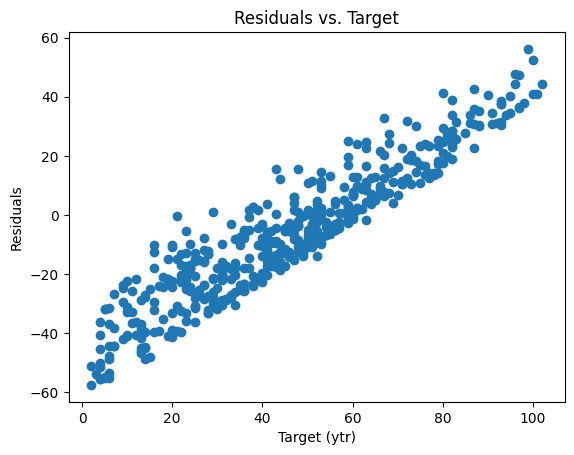

In [13]:
# Evaluate the model
ytr_pred_wgt = lr_weighted.predict(Xtr)


mse = mean_squared_error(ytr, ytr_pred_wgt)
print("Mean Squared Error on training data:", mse)

r2 = r2_score(ytr, ytr_pred_wgt)
print("R-squared:", r2)

# Let's look at the residuals:
residuals_wgt = ytr - ytr_pred_wgt
#residuals_wgt = residuals_wgt**2

plt.scatter(ytr, residuals_wgt)
plt.xlabel("Target (ytr)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Target")
plt.show()

<p><font size="4"><i>

Surprising that this did worse. Maybe too many bins? Maybe not enough bins? 

<p><font size="4"><i>

At this point, underfitting is a possibililty, but's let's try Lasso Regression to try to gain some additional insight into the dominant/irrelevant features.

In [14]:
# Train a lasso regression model using cross validation to find the best learning rate "alpha"
lasso_cv = LassoCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)  # Adjust the alphas as needed
lasso_cv.fit(Xtr, ytr)

# Optimal alpha and coefficients
print("Optimal alpha:", lasso_cv.alpha_)
print("Lasso Coefficients with optimal alpha:", lasso_cv.coef_)

# Create & print a table of the feature importance
features = df_Xtr.columns.to_list()

df_features = pd.DataFrame({'Feature': features})
df_features['feature_importance'] = np.abs(lasso_cv.coef_)
df_sorted = df_features.sort_values(by='feature_importance', ascending=False)
df_sorted.head(20)

Optimal alpha: 0.1
Lasso Coefficients with optimal alpha: [-2.17560218 -0.96527189 -0.01396919  0.24690139  0.80146435 -0.25062773
 -0.         -0.20184541  7.16724215  9.37935158  8.33046462 -2.8438418
  0.          0.         -0.          5.41521849  0.         -0.
  0.        ]


,Feature,feature_importance
9,Estrogen Status,9.379352
10,Progesterone Status,8.330465
8,A Stage,7.167242
15,Marital Status_Married,5.415218
11,Race _Black,2.843842
0,Age,2.175602
1,Tumor Size,0.965272
4,T Stage,0.801464
5,N Stage,0.250628
3,Reginol Node Positive,0.246901


<p><font size="4"><i>
Maybe reasonable. The questionable ones are:

* "Married." I think that is more because it is a dominant feature.
* "A Stage." Regional, value = 1 is dominant

Let's retrain the model using only the non zero features.

In [15]:
# Get the indices of selected features (where coefficient is non-zero)
selected_features = np.where(lasso_cv.coef_ != 0)[0]
print("Selected features:", selected_features)

# Use only the selected features to train a linear regression model
Xtr_selected = Xtr[:, selected_features]
Xts_selected = Xts[:, selected_features]

# Train the Linear Regression model on selected features
las_r = LinearRegression()
las_r.fit(Xtr_selected, ytr)
las_r.coef_

Selected features: [ 0  1  2  3  4  5  7  8  9 10 11 15]


array([-2.40023079, -1.36869102, -0.36613682,  1.04083714,  1.42261629,
       -0.79881928, -0.38416257,  9.34898514,  9.73778178,  8.51084235,
       -3.6246505 ,  5.69188931])

Mean Squared Error on training data: 507.01242422886065
R-squared: 0.11926012514272688


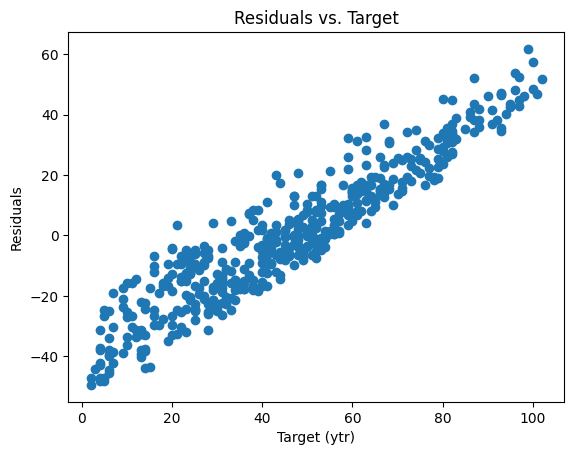

In [16]:
# Evaluate the model
ytr_sel_pred = las_r.predict(Xtr_selected)

mse_sel = mean_squared_error(ytr, ytr_sel_pred)
print("Mean Squared Error on training data:", mse_sel)

r2 = r2_score(ytr, ytr_sel_pred)
print("R-squared:", r2)

# Let's look at the residuals:
residuals_sel = ytr - ytr_sel_pred
residuals_sel_sqd = residuals**2

plt.scatter(ytr, residuals_sel)
plt.xlabel("Target (ytr)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Target")
plt.show()

<p><font size="4"><i>
Looks about the same. The target at this point, is just feature selection. Feature selection can be valid even if MSE is not reduced. 

Let's use intuition to further reduce the features. As written above, T Stage & N Stage are redundant. They are included in A stage. Let's drop them and retrain the model.

In [17]:
values_to_remove = [4, 5]
mask = ~(np.isin(selected_features, values_to_remove))
print(mask)
# Apply the mask to the array
refined_features = selected_features[mask]

print(refined_features)  

[ True  True  True  True False False  True  True  True  True  True  True]
[ 0  1  2  3  7  8  9 10 11 15]


In [18]:
# Use only the selected features to train a linear regression model
Xtr_refined = Xtr[:, refined_features]
Xts_refined = Xts[:, refined_features]

# Train the Linear Regression model on selected features
las_rr = LinearRegression()
las_rr.fit(Xtr_refined, ytr)
las_rr.coef_

array([-2.4212041 , -0.54732469, -0.36309018,  0.52460882, -0.43686646,
        9.04446151,  9.84824649,  8.5327502 , -3.7083805 ,  5.79187322])

Mean Squared Error on training data: 507.73543326586474
R-squared: 0.11800417389115703


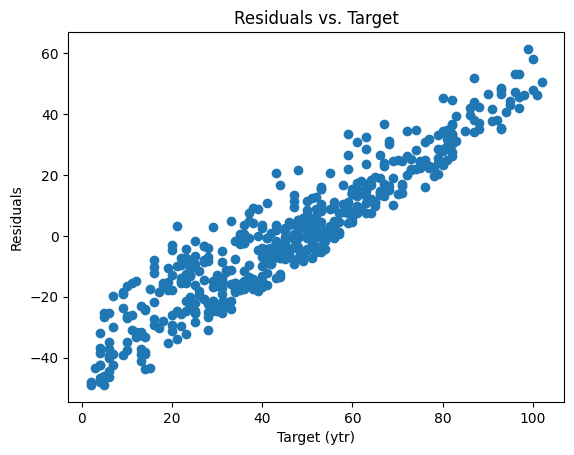

In [19]:
# Evaluate the model
ytr_ref_pred = las_rr.predict(Xtr_refined)

mse_ref = mean_squared_error(ytr, ytr_ref_pred)
print("Mean Squared Error on training data:", mse_ref)

r2 = r2_score(ytr, ytr_ref_pred)
print("R-squared:", r2)

# Let's look at the residuals:
residuals_ref = ytr - ytr_ref_pred
residuals_ref_sqd = residuals_ref**2

plt.scatter(ytr, residuals_ref)
plt.xlabel("Target (ytr)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Target")
plt.show()

<p><font size="4"><i>
Reduction in features reduces performance, which is inline with an underfit model.

<p><font size="4"><i>
At this point, let's try to add complexitiy to the model. SVR provides a non linear kernel. Let's try SVR using grid search with cross validation to find the best hyperparameters.

In [20]:
# Try support vector regression
svr = SVR()

# Define hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],  # Regularization parameter
    'epsilon': [0.1, 0.2, 0.5, 0.75, 1.0],  # Epsilon-tube for no penalty
    'kernel': ['rbf'],  # Kernel type
}

# Perform grid search
grid_search = GridSearchCV(estimator=svr, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1)
grid_search.fit(Xtr, ytr)

# Best parameters and corresponding score
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'C': 10, 'epsilon': 0.1, 'kernel': 'rbf'}


Mean Squared Error on Test Data: 474.1066589660212
R-squared: 0.17642128766010545


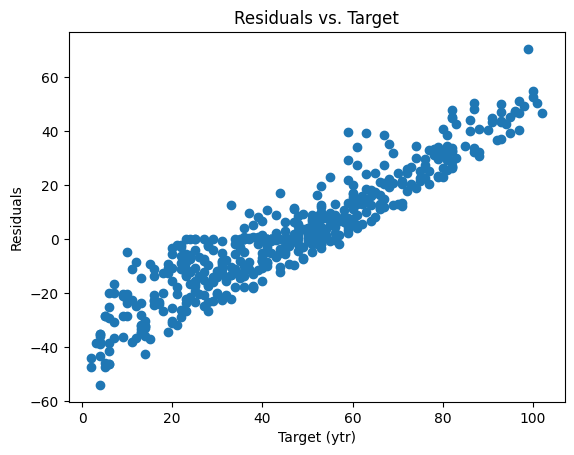

In [21]:
# Evaluate 
y_pred_svr = best_model.predict(Xtr)

mse_svr = mean_squared_error(ytr, y_pred_svr)
print("Mean Squared Error on Test Data:", mse_svr)

r2 = r2_score(ytr, y_pred_svr)
print("R-squared:", r2)

# Let's look at the residuals:
residuals_svr = ytr - y_pred_svr

plt.scatter(ytr, residuals_svr)
plt.xlabel("Target (ytr)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Target")
plt.show()

<p><font size="4"><i>
Much better, but still not great.

Lastly, let's try Gradient Boosted Regression Tree:

In [22]:
# Apply grid search to select the best hyper parameters for Gradient Boosting:
param_grid = {
    "n_estimators": [100, 500, 750],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1],
    'min_samples_leaf': [1, 2, 4],
}

gr_bst_reg = GradientBoostingRegressor()

grid_search = GridSearchCV(
    estimator=gr_bst_reg,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,  # Use all available cores for faster processing
#    verbose=2   # Increase verbosity to see progress
)

grid_search.fit(Xtr, ytr)

best_params_gbr = grid_search.best_params_
best_model_gbr = grid_search.best_estimator_
best_score_gbr = -grid_search.best_score_  # Convert to positive MSE for interpretability

print("Best Parameters:", best_params_gbr)
print("Best MSE for Cross Validation:", best_score_gbr)

Best Parameters: {'learning_rate': 0.01, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 100}
Best MSE for Cross Validation: 557.8451069331443


Mean Squared Error on Training Data: 495.76753502303075
R-squared: 0.13879381275795577


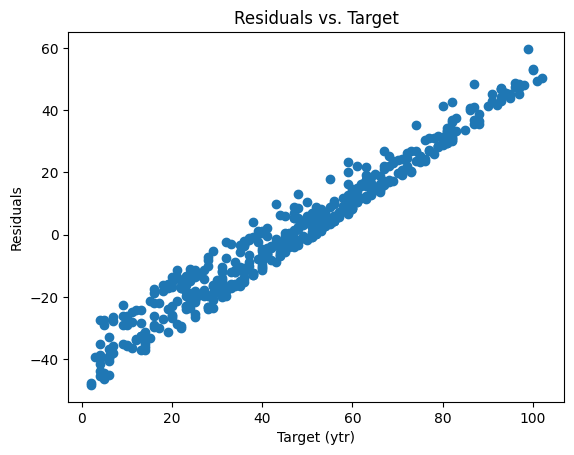

In [23]:
# Evaluate 
y_pred_gbr = best_model_gbr.predict(Xtr)

mse_gbr = mean_squared_error(ytr, y_pred_gbr)
print("Mean Squared Error on Training Data:", mse_gbr)

r2 = r2_score(ytr, y_pred_gbr)
print("R-squared:", r2)

# Let's look at the residuals:
residuals_gbr = ytr - y_pred_gbr

plt.scatter(ytr, residuals_gbr)
plt.xlabel("Target (ytr)")
plt.ylabel("Residuals")
plt.title("Residuals vs. Target")
plt.show()